# Links between air pollution and COVID-19 in England #

### AIM 1: PRELIMINARY ANALYSIS AND REGIONAL LEVEL ANALYSIS ###
1. [Data visualization](#preliminary)
2. [Link between COVID-19 deaths and air pollution](#deaths)
3. [Link between COVID-19 cases and air pollution](#cases)
4. [conclusion](#end)

Import the modules I need for the analysis and the paths where the data are stores, all included in the [conf_files](./conf_files.ipynb)

In [24]:
%run conf_files.ipynb

The first dataset needed is preL_dt, whose contents is described in [data](../Data/datasets.ipynb#preL_dt)

In [23]:
preL_dt = pd.read_csv("%s/26-4-2020_yyAIR_COVID_PRE_LD_dt.csv" %path)
preL_dt=preL_dt.loc[:,"Region":] #the first column contained indexes
preL_dt.head()

,Region,cases_preL,deaths_preL,Date_cases,Population_size_2018,Average_Pop_density_personkm2,Cases,Deaths,NO.levels,NO2.levels,O3.levels
0,East Of England,5356,746,NaN,6201214,324.0,6499,1448,9.502135,19.553718,54.367479
1,London,16913,2120,NaN,8908081,5666.0,19511,3522,25.193133,38.512520,36.913913
2,Midlands,10501,1491,NaN,10704906,380.5,14844,2684,14.529437,24.119851,47.698892
3,North East And Yorkshire,8004,893,NaN,8137524,333.0,10633,1641,16.501209,25.151394,45.295342
4,North West,9394,847,NaN,7292093,517.0,12093,1801,8.581661,20.062745,48.950810


Standardize the variables so that I can display all them together 

In [25]:
#keep only numerical columns to normalize them
preL_dt_1=preL_dt.drop(columns=['Region',"Date_cases"])

#standardize
zs = StandardScaler()
preL_dt_st = zs.fit_transform(preL_dt_1)
preL_dt_st #it is standardized but it is an array, not a dataframe

cols=list(preL_dt_1.columns)#take columns' names
preL_dt_st=pd.DataFrame(preL_dt_st, columns=cols)

preL_dt_st['Region']=preL_dt['Region'] #add region col again
preL_dt_st.head()

,cases_preL,deaths_preL,Population_size_2018,Average_Pop_density_personkm2,Cases,Deaths,NO.levels,NO2.levels,O3.levels,Region
0,-0.844810,-0.537114,-1.091478,-0.436976,-0.987511,-0.487041,-0.884927,-0.768450,1.290319,East Of England
1,1.988584,2.012719,0.553993,2.446688,1.744846,1.871485,2.107078,2.323251,-2.064650,London
2,0.416574,0.845437,1.646261,-0.406477,0.764834,0.918522,0.073693,-0.023829,0.008466,Midlands
3,-0.195608,-0.264315,0.085581,-0.432118,-0.119423,-0.267564,0.449677,0.144389,-0.453550,North East And Yorkshire
4,0.145174,-0.349681,-0.428346,-0.332793,0.187159,-0.085614,-1.060446,-0.685441,0.249113,North West


 <a id='preliminary'></a>
### Visualize the distribution of each variable

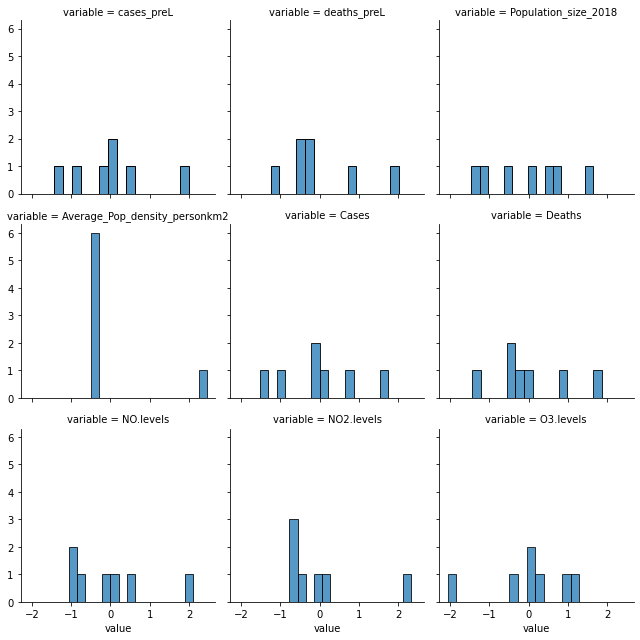

In [7]:
preL_dt_new=pd.melt(preL_dt_st, id_vars='Region')
g = sns.FacetGrid(preL_dt_new, col='variable', col_wrap=3)
g.map(sns.histplot, 'value', bins=15)

From the histograms we can see that:
- all the 7 regions have different population size, but similar average population density (except for one region that is highly density populated)
- almost every region has very different number of deaths and cases
- all of the three pollutants have different average for almost each region

I propose here two different visualizations, useful to investigate relationships between variables.
From the first plot we can investigate easier the comparison between regions.
For example, we can see how London is the Region with the highest values for all variable expect for ozone.

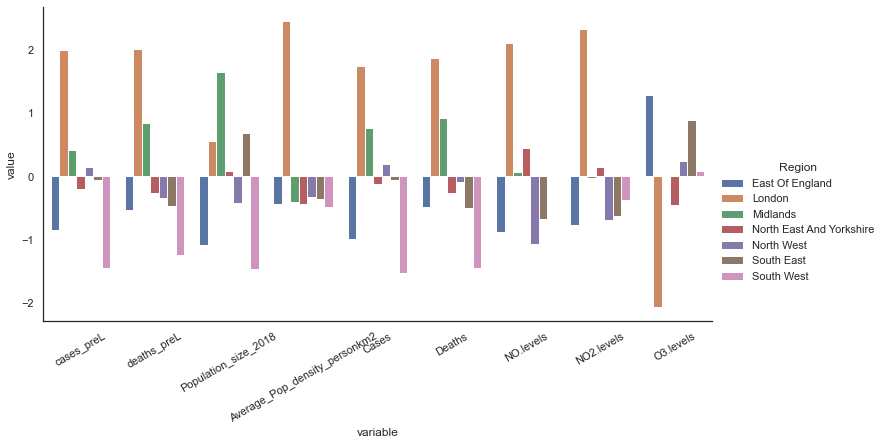

In [8]:
sns.set(style="white")
g = sns.catplot(x='variable'
                   ,y= 'value'
                   ,hue='Region'
                   ,data=preL_dt_new
                   ,kind='bar'
                   ,aspect=2
                   )
g.set_xticklabels(rotation=30);

In this second plot we can look at the possible correlation between variables within the same region, that is more interesting.
It is quite evident that number of cases and deaths above the mean comes together with high value for all the other variables but ozone.

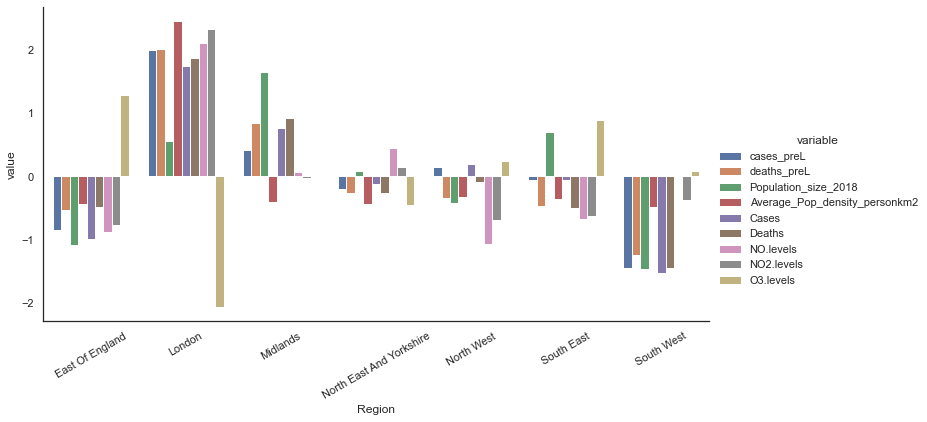

In [9]:
sns.set(style="white")
g = sns.catplot(x='Region'
                   ,y= 'value'
                   ,hue='variable'
                   ,data=preL_dt_new
                   ,kind='bar'
                   ,aspect=2
                   )
g.set_xticklabels(rotation=30);

Other regional level visualization can be found in the [regional level map notebook](../Maps/regional_level_map.ipynb)

<a id='deaths'></a>
### Analyse deaths data: linear, negative binomial and Poisson regression model 

After preliminary analysis, let's investigate the relationship between air pollution and expected number of covid19 deaths throught model fits. 
Regression models with pre-lockdown deaths as dependent variable and the three air pollutants as regressors are fitted. All models contain the average population density beacause it could act as a confounder.

##### Linear regression model

In [10]:
x=sm.add_constant(preL_dt.loc[:,['Average_Pop_density_personkm2','NO.levels','NO2.levels','O3.levels']]) #regressors matrix
y=preL_dt.loc[:,['deaths_preL']] #dependent variable

model = sm.OLS(y, x).fit() #ols
print("AIC: ", model.aic)
model.summary()

AIC:  96.04651561142177


C:\Users\biagi\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            deaths_preL   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     10.87
Date:                Sat, 02 Oct 2021   Prob (F-statistic):             0.0860
Time:                        10:48:33   Log-Likelihood:                -43.023
No. Observations:                   7   AIC:                             96.05
Df Residuals:                       2   BIC:                             95.78
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -1.235e+04   4843.598     -2.549      0.126   -3.32e+04    8494.212
Average_Pop_density_personkm2    -0.6310      0.254     -2.480      0.131      -1.726       0.464
NO.levels                      -332.5735    112.432     -2.958      0.098    -816.328     151.181
NO2.levels                      601.4702    178.233      3.375      0.078    -165.402    1368.343
O3.levels                        88.2410     54.093      1.631      0.244    -144.503     320.985
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.539
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.100
Skew:                          -0.009   Prob(JB):                        0.951
Kurtosis:                       2.416   Cond. No.                     1.32e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model does not work well with the data. The variablity is much higher than expected, suggesting overdispersion.
Having count data, it could be better to fit a Poisson or a negative binomial regression.

##### Negative binomial regression model

In [29]:
# tranform in thousands
preL_dt['NO.levels'] = round(preL_dt['NO.levels']*1000)
preL_dt['NO2.levels'] = round(preL_dt['NO2.levels']*1000)
preL_dt['O3.levels'] = round(preL_dt['O3.levels']*1000)
preL_dt['Average_Pop_density_personkm2'] = round(preL_dt['Average_Pop_density_personkm2'])

preL_dt.rename(columns={'NO.levels':'NO_levels', 'NO2.levels':'NO2_levels', 'O3.levels':'O3_levels'}, inplace=True)
#variables' names cannot contain dot when written in the formula for regression

In [31]:
mod_deaths_nbin = smf.glm(formula = "deaths_preL~ Average_Pop_density_personkm2 + NO_levels + NO2_levels + O3_levels", data=preL_dt, family=sm.families.NegativeBinomial(alpha=0.005102041)).fit()
print("AIC: ", mod_deaths_nbin.aic)
mod_deaths_nbin.summary()

AIC:  89.74529249696116


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            deaths_preL   No. Observations:                    7
Model:                            GLM   Df Residuals:                        2
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -39.873
Date:                Sat, 02 Oct 2021   Deviance:                       6.9413
Time:                        17:44:13   Pearson chi2:                     6.93
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -10.8994      1.892     -5.762      0.000     -14.607      -7.192
Average_Pop_density_personkm2    -0.0009   9.84e-05     -9.486      0.000      -0.001      -0.001
NO_levels                        -0.0005   4.49e-05    -10.531      0.000      -0.001      -0.000
NO2_levels                        0.0008   7.09e-05     11.473      0.000       0.001       0.001
O3_levels                         0.0001   2.07e-05      5.797      0.000    7.94e-05       0.000
=================================================================================================
"""

In [32]:
mod_deaths_nbin.pearson_chi2

6.932544443146632

In [33]:
print("20 unit increase of NO :", np.exp(-0.0005*20))
print("20 unit increase of NO2 :", np.exp(0.0008*20))
print("20 unit increase of O3 :", np.exp(0.0001*20))

20 unit increase of NO : 0.9900498337491681
20 unit increase of NO2 : 1.016128685406095
20 unit increase of O3 : 1.0020020013340003


Here units are μg/m3 * 1000

In term of AIC and Pearson chi2 test the model is better thant the linear regression one. Now the standard errors are not as huge as before. All the regressors are statistically significant, so that it seems that they all have influence on the number of deaths.
For a 20 units increase of NO level, the expected number of deaths decreases of 0.05%.
For a 20 units increase of NO2 level, the expected number of deaths increases of a 1.6%.
For a 20 units increase of O3 level, the expected number of deaths increases of less than 1%

##### Poisson regression model

In [34]:
#poisson fit
mod_deaths_poi = smf.glm(formula = "deaths_preL~ Average_Pop_density_personkm2 + NO_levels + NO2_levels + O3_levels", data=preL_dt, family=sm.families.Poisson()).fit()
print("AIC: ", mod_deaths_poi.aic)
print(mod_deaths_poi.pearson_chi2)
mod_deaths_poi.summary()

AIC:  109.09393382424423
38.45457211581487


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            deaths_preL   No. Observations:                    7
Model:                            GLM   Df Residuals:                        2
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49.547
Date:                Sat, 02 Oct 2021   Deviance:                       38.539
Time:                        17:44:15   Pearson chi2:                     38.5
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -11.5904      0.909    -12.749      0.000     -13.372      -9.809
Average_Pop_density_personkm2    -0.0010   4.57e-05    -21.381      0.000      -0.001      -0.001
NO_levels                        -0.0005    2.3e-05    -21.360      0.000      -0.001      -0.000
NO2_levels                        0.0008   3.57e-05     23.681      0.000       0.001       0.001
O3_levels                         0.0001   9.46e-06     13.180      0.000       0.000       0.000
=================================================================================================
"""

Likewise the negative binomial the coefficients are all statistically significant. They also have almost the same interpretation as before. In terms of AIC and Pearson chi2 the Poisson model is worst than the negative binomial one. 

<a id='cases'></a>
### Analyse case data: linear, negative binomial and Poisson regression model to explore the relationship

Linear, negative binomial and Poisson regression model with pre-lockdown cases as dependent variable and the same regressors as before are fitted. 
The linear model is overdispersed again and the negative binomial turns out to have a lower AIC.

##### Linear and Poisson regression models

In [16]:
#linear model fit
x=sm.add_constant(preL_dt.loc[:,['Average_Pop_density_personkm2','NO_levels','NO2_levels','O3_levels']])
y=preL_dt.loc[:,['cases_preL']]
model_cases = sm.OLS(y, x).fit()
model_cases.summary()
print("AIC OLS: ", model_cases.aic)

#poisson fit
mod_cases_poi = smf.glm(formula = "cases_preL~ Average_Pop_density_personkm2 + NO_levels + NO2_levels + O3_levels", data=preL_dt, family=sm.families.Poisson()).fit()
mod_cases_poi.summary()
print("AIC Poisson: ", mod_cases_poi.aic)
mod_cases_poi.pearson_chi2

AIC OLS:  126.95921854067365
AIC Poisson:  1436.0812219835716


C:\Users\biagi\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


1409.4671590048458

##### Negative binomial regression model

In [17]:
mod_cases_nbin = smf.glm(formula = "cases_preL~ Average_Pop_density_personkm2 + NO_levels + NO2_levels + O3_levels", data=preL_dt, family=sm.families.NegativeBinomial(alpha=0.02985075)).fit()
print(mod_cases_nbin.summary())
print("AIC: ", mod_cases_nbin.aic)
mod_cases_nbin.pearson_chi2

                 Generalized Linear Model Regression Results                  
Dep. Variable:             cases_preL   No. Observations:                    7
Model:                            GLM   Df Residuals:                        2
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -60.434
Date:                Sat, 02 Oct 2021   Deviance:                       7.0308
Time:                        10:48:34   Pearson chi2:                     7.51
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

7.509495032937853

In [18]:
print("20 unit increase of NO :", np.exp(-0.0005*20))
print("20 unit increase of NO2 :", np.exp(0.0007*20))

20 unit increase of NO : 0.9900498337491681
20 unit increase of NO2 : 1.0140984589384923


Here units are μg/m3 * 1000

Only NO and NO2 are statistically significant. Ozone does not has a significant effect on the expected number of cases 
For a 20 units increase of NO level, the expected number of cases decrese of almost than 1%. 
For a 20 units increase of NO2 level, the expected number of cases increase of a 1.4%. 

The obtained results are saved in html tables ([deaths models](../data_out/regional_deaths_models.html), [cases models](../data_out/regional_cases_models.html))

In [19]:
### produce an html file for deaths models
regional_deaths_models = Stargazer([mod_deaths_nbin, mod_deaths_poi])
regional_deaths_models.show_confidence_intervals(True)
regional_deaths_models.custom_columns(['negative binomial', 'poisson'], [1, 1])
html = open("../data_out/regional_deaths_models.html","w")
html.write(regional_deaths_models.render_html())
html.close()

In [20]:
### produce an html file for cases models
regional_cases_models = Stargazer([mod_cases_nbin, mod_cases_poi])
regional_cases_models.show_confidence_intervals(True)
regional_cases_models.custom_columns(['negative binomial', 'poisson'], [1, 1])
html = open("../data_out/regional_cases_models.html","w")
html.write(regional_cases_models.render_html())
html.close()

<a id='id'></a>
### Conclusion

The levels of nitrogen oxide and nitrogen dioxide are significant predictors of COVID-19 cases, independent of the population density.

Ozone, nitrogen oside and nitrogen dioxidea are significantly associated with COVID-19 deaths together with the population density.